# 0.0 IMPORT

In [1]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot         as plt
import seaborn                   as sns
import pandas                    as pd
import numpy                     as np

from sklearn.model_selection     import train_test_split
from imblearn.over_sampling      import SMOTE
from sklearn.preprocessing       import OneHotEncoder, MinMaxScaler
from sklearn.linear_model        import LogisticRegression
from sklearn.ensemble            import RandomForestClassifier
from sklearn.metrics             import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.tree                import DecisionTreeClassifier
from sklearn.svm                 import SVC
from xgboost                     import XGBClassifier

import pickle
import pylab


%matplotlib inline

## 0.1 Help Functions

In [2]:
# Converte um objeto do tipo string em float.
def converter_str_float(entrada):
    try:
        return float(entrada)
    except ValueError:
        return np.nan

#tamanho dos gráficos
def tamanho( x, y ):
    pylab.rcParams['figure.figsize'] = (x, y)

## 0.2 Loading Dataset

In [3]:
df_raw = pd.read_csv('dataset/churn-dados.csv', low_memory = False)

# 1.0 DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw.copy()

In [5]:
df1 = df1.rename(columns={'customerID': 'id', 'gender': 'genero', 'SeniorCitizen': 'antigo', 'Dependents': 'dependentes',
                         'tenure': 'posse', 'PhoneService': 'servico_telefone', 'MultipleLines': 'linhas_multiplas',
                         'InternetService': 'servico_internet', 'OnlineSecurity': 'seguranca_online', 
                          'OnlineBackup': 'backup_online', 'DeviceProtection': 'protecao_dispositivo',
                          'TechSupport': 'suporte_tecnico', 'StreamingTV': 'streaming_tv', 'StreamingMovies': 'streaming_video',
                          'Contract': 'contrato', 'PaperlessBilling': 'faturamento_sem_papel', 'PaymentMethod': 'metodo_pagamento',
                          'MonthlyCharges': 'mensalidade', 'TotalCharges': 'custos_totais', 'Partner': 'parceiro', 
                          'Churn': 'churn'})

In [6]:
df1.head()

,id,genero,antigo,parceiro,dependentes,posse,servico_telefone,linhas_multiplas,servico_internet,seguranca_online,...,protecao_dispositivo,suporte_tecnico,streaming_tv,streaming_video,contrato,faturamento_sem_papel,metodo_pagamento,mensalidade,custos_totais,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 1.1. Dimensão dos dados

In [7]:
print ('Numero de linhas: {}'.format(df1.shape[0]))
print ('Numero de colunas: {}'.format(df1.shape[1]))

Numero de linhas: 7043
Numero de colunas: 21


## 1.2. Tipos de dados

In [8]:
df1.dtypes

id                        object
genero                    object
antigo                     int64
parceiro                  object
dependentes               object
posse                      int64
servico_telefone          object
linhas_multiplas          object
servico_internet          object
seguranca_online          object
backup_online             object
protecao_dispositivo      object
suporte_tecnico           object
streaming_tv              object
streaming_video           object
contrato                  object
faturamento_sem_papel     object
metodo_pagamento          object
mensalidade              float64
custos_totais             object
churn                     object
dtype: object

In [9]:
df1["custos_totais"] = df1["custos_totais"].apply(converter_str_float)


## 1.3. Check NA

In [10]:
df1.isna().sum()

id                        0
genero                    0
antigo                    0
parceiro                  0
dependentes               0
posse                     0
servico_telefone          0
linhas_multiplas          0
servico_internet          0
seguranca_online          0
backup_online             0
protecao_dispositivo      0
suporte_tecnico           0
streaming_tv              0
streaming_video           0
contrato                  0
faturamento_sem_papel     0
metodo_pagamento          0
mensalidade               0
custos_totais            11
churn                     0
dtype: int64

## 1.4. Descrição Estatística

In [11]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

In [12]:
num_attributes.nunique()

antigo              2
posse              73
mensalidade      1585
custos_totais    6530
dtype: int64

In [13]:
cat_attributes.nunique()

id                       7043
genero                      2
parceiro                    2
dependentes                 2
servico_telefone            2
linhas_multiplas            3
servico_internet            3
seguranca_online            3
backup_online               3
protecao_dispositivo        3
suporte_tecnico             3
streaming_tv                3
streaming_video             3
contrato                    3
faturamento_sem_papel       2
metodo_pagamento            4
churn                       2
dtype: int64

In [14]:
df1.describe()

,antigo,posse,mensalidade,custos_totais
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


# 2.0 FEATURE ENGINEERING

In [15]:
df2 = df1.copy()

In [16]:
novos_valores = {'Yes':1, 'No':0}
df2['churn'] = df2['churn'].map(novos_valores)
df2['dependentes'] = df2['dependentes'].map(novos_valores)
df2['suporte_tecnico'] = df2['suporte_tecnico'].map(novos_valores)

In [17]:
df2.head()

,id,genero,antigo,parceiro,dependentes,posse,servico_telefone,linhas_multiplas,servico_internet,seguranca_online,...,protecao_dispositivo,suporte_tecnico,streaming_tv,streaming_video,contrato,faturamento_sem_papel,metodo_pagamento,mensalidade,custos_totais,churn
0,7590-VHVEG,Female,0,Yes,0,1,No,No phone service,DSL,No,...,No,0.0,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,0,34,Yes,No,DSL,Yes,...,Yes,0.0,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,0,2,Yes,No,DSL,Yes,...,No,0.0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,0,45,No,No phone service,DSL,Yes,...,Yes,1.0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,0,2,Yes,No,Fiber optic,No,...,No,0.0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


# 3.0 FILTRAGEM DE VARIAVEIS

In [18]:
df3 = df2.copy()

In [19]:
df3.drop("id", axis=1, inplace=True)

In [20]:
df3.head()

,genero,antigo,parceiro,dependentes,posse,servico_telefone,linhas_multiplas,servico_internet,seguranca_online,backup_online,protecao_dispositivo,suporte_tecnico,streaming_tv,streaming_video,contrato,faturamento_sem_papel,metodo_pagamento,mensalidade,custos_totais,churn
0,Female,0,Yes,0,1,No,No phone service,DSL,No,Yes,No,0.0,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,0,34,Yes,No,DSL,Yes,No,Yes,0.0,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,0,2,Yes,No,DSL,Yes,Yes,No,0.0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,0,45,No,No phone service,DSL,Yes,No,Yes,1.0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,0,2,Yes,No,Fiber optic,No,No,No,0.0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


# 4.0 Análise Exploratória de Dados (EDA)

In [21]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Variável Resposta

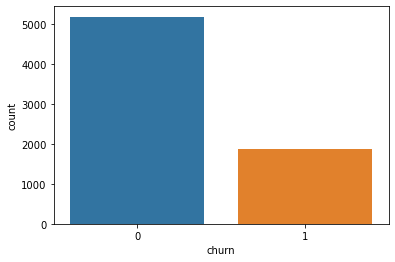

In [22]:
sns.countplot(df4['churn']);

### 4.1.2. Variável Numérica

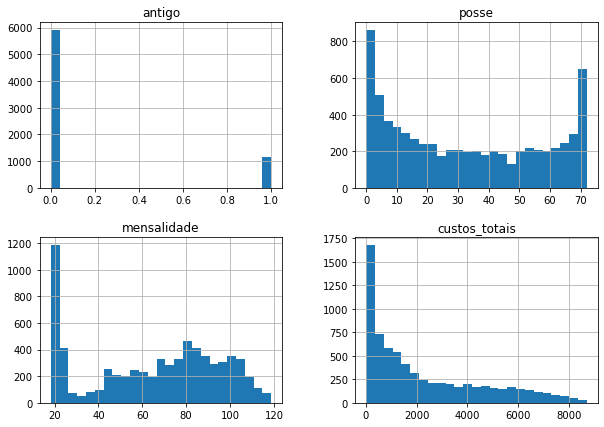

In [23]:
num_attributes.hist(bins=25, figsize=(10, 7));

### 4.1.3. Variáveis Categóricas

In [24]:
cat_attributes.columns

Index(['id', 'genero', 'parceiro', 'dependentes', 'servico_telefone',
       'linhas_multiplas', 'servico_internet', 'seguranca_online',
       'backup_online', 'protecao_dispositivo', 'suporte_tecnico',
       'streaming_tv', 'streaming_video', 'contrato', 'faturamento_sem_papel',
       'metodo_pagamento', 'churn'],
      dtype='object')

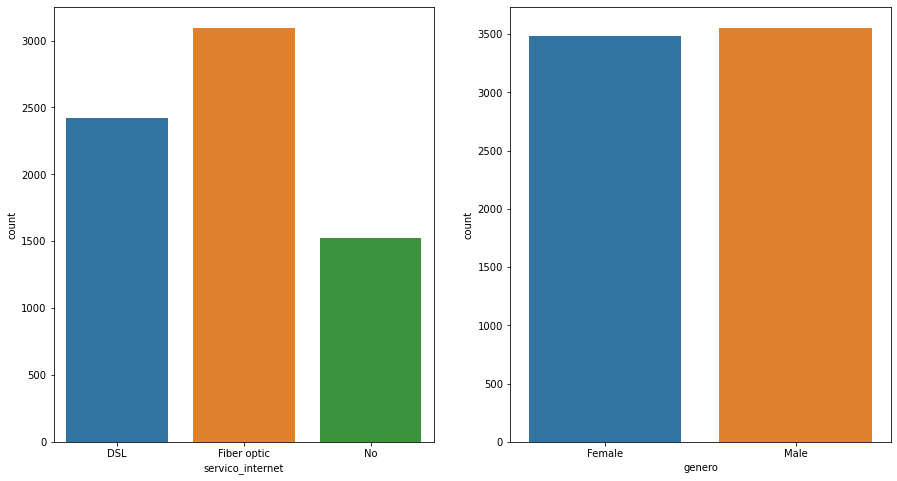

In [25]:
pylab.rcParams['figure.figsize'] = (15.0, 8.0)
plt.subplot(1, 2, 1)
sns.countplot(df4['servico_internet']);

plt.subplot(1, 2, 2)
sns.countplot(df4['genero']);

## 4.2. Análise Bivariada

In [26]:
df4.head(2)

,genero,antigo,parceiro,dependentes,posse,servico_telefone,linhas_multiplas,servico_internet,seguranca_online,backup_online,protecao_dispositivo,suporte_tecnico,streaming_tv,streaming_video,contrato,faturamento_sem_papel,metodo_pagamento,mensalidade,custos_totais,churn
0,Female,0,Yes,0,1,No,No phone service,DSL,No,Yes,No,0.0,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,0,34,Yes,No,DSL,Yes,No,Yes,0.0,No,No,One year,No,Mailed check,56.95,1889.50,0


#### P1. Deveria haver mais churns entre os homens.
**Inconclusivo,** a maioria de rotatividade é de clientes do sexo feminino

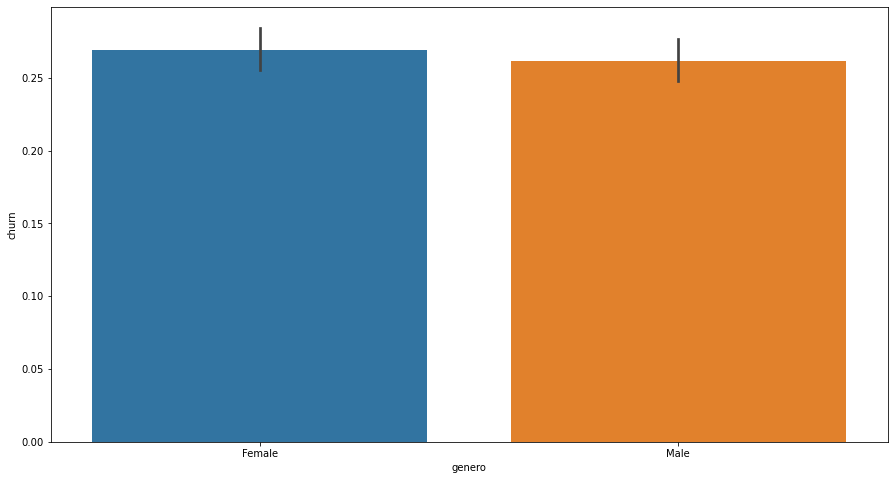

In [27]:
aux = df4[(df4['genero'] != '0') & (df4['churn'] > 0)]
pylab.rcParams['figure.figsize'] = (15.0, 8.0)
sns.barplot(x='genero', y='churn', data=df4 );

#### P2. Clientes mais antigos deveriam ter menos churns.
**Verdade,** é mais comum os clientes novos tender a rotatividade.

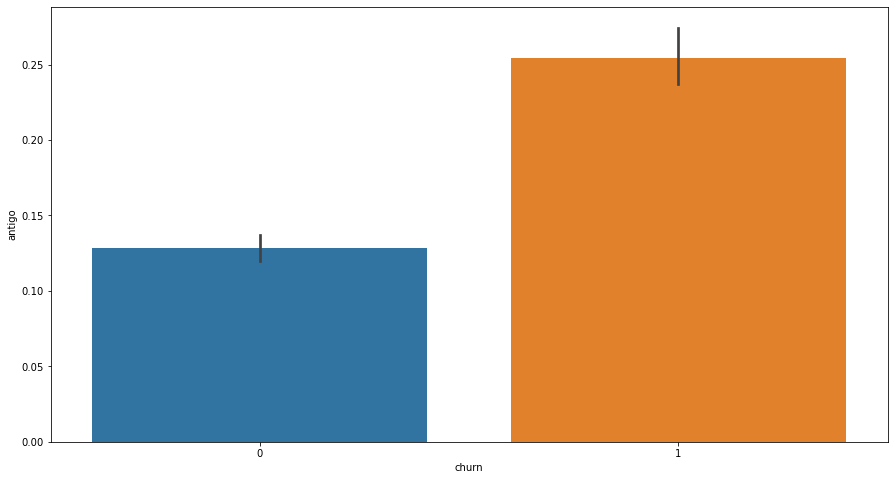

In [28]:
sns.barplot(x='churn', y='antigo', data=df4 );

#### P3. As mensalidades devem ser maior para quem utiliza streaming_video
**Verdade,**, as mensalidades são maiores para utilizadores de streaming de vídeos

<AxesSubplot:>

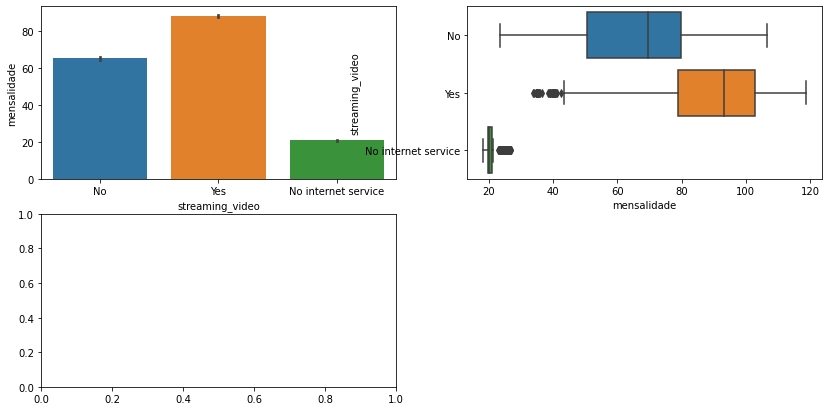

In [29]:
tamanho(14, 7)
plt.subplot(2, 2, 1)
sns.barplot(x='streaming_video', y='mensalidade', data=df4);

plt.subplot(2, 2, 2)
sns.boxplot(x='mensalidade', y='streaming_video', data=df4);

plt.subplot( 2, 2, 3 ) 

In [30]:
#df4['streaming_video'].unique()

#sns.kdeplot ( df4[df4['streaming_video'] == 'Yes']['mensalidade'], label = a, shade = True)
#sns.kdeplot ( df4[df4['streaming_video'] == 'No']['mensalidade'], label = b, shade = True)
#sns.kdeplot ( df4[df4['streaming_video'] == 'No internet service']['mensalidade'], label = c, shade = True)

In [31]:
#sns.kdeplot ( df4[df4['streaming_video'] == 'Yes']['mensalidade'], label = 'a', shade = True)
#sns.kdeplot ( df4[df4['streaming_video'] == 'No']['mensalidade'], label = 'b', shade = True)
#sns.kdeplot ( df4[df4['streaming_video'] == 'No internet service']['mensalidade'], label = 'c', shade = True);

#### P4. Quanto mais antigo o cliente for, menor deveria ser os custos totais do plano.
**Verdade,** os custos abaixam conforme ao passar do tempo

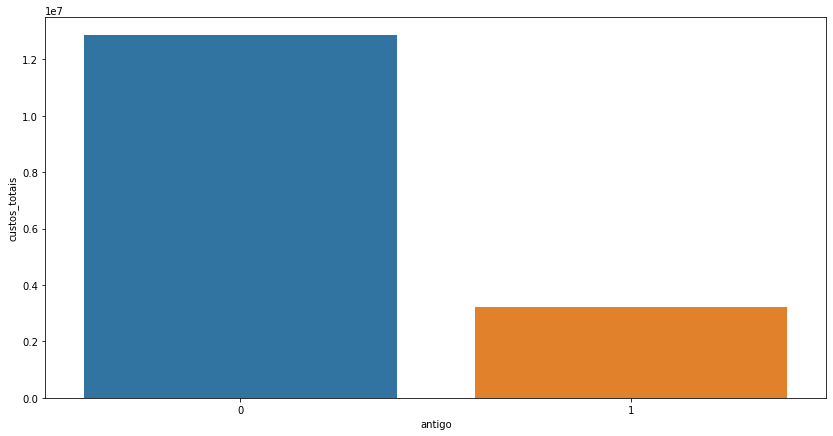

In [32]:
aux1 = df4[['antigo', 'custos_totais']].groupby('antigo').sum().reset_index()
sns.barplot( x='antigo', y='custos_totais', data=aux1);

#### P5. Se tiver dependentes, a tendência é uma menor rotação.
**Verdade,** quando não se tem dependentes, o churn é maior

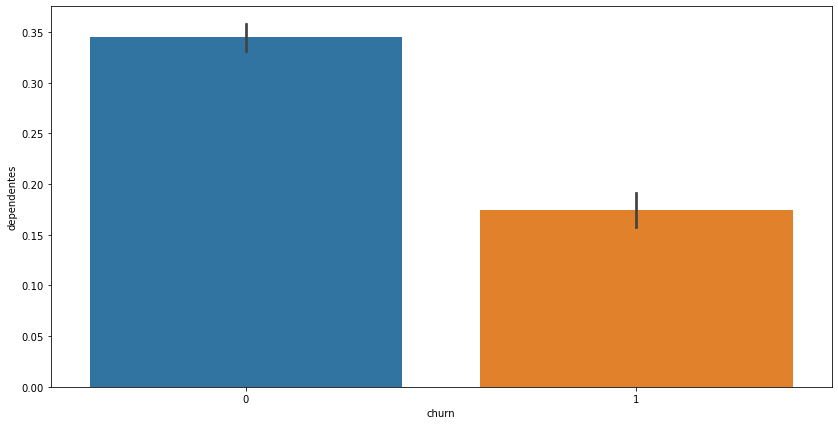

In [33]:
sns.barplot(x='churn', y='dependentes', data=df4);

#### P6. Se o plano do assinante possuir suporte técnico, a tendência é que o churn aconteça com menos frequência.
**Verdade,** a rotatividade maior é para quem não possui suporte técnico no seu plano.

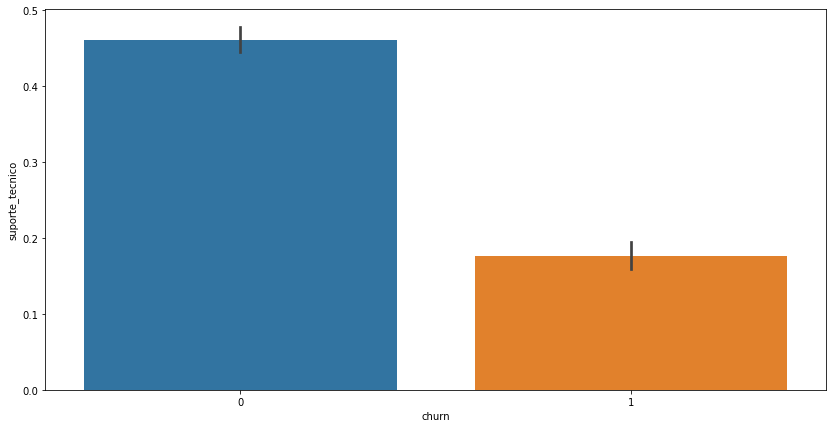

In [34]:
sns.barplot(x='churn', y='suporte_tecnico', data=df4);

#### P7. Se o plano do assinante possuir backup online, a tendência é que o churn aconteça com menos frequência.

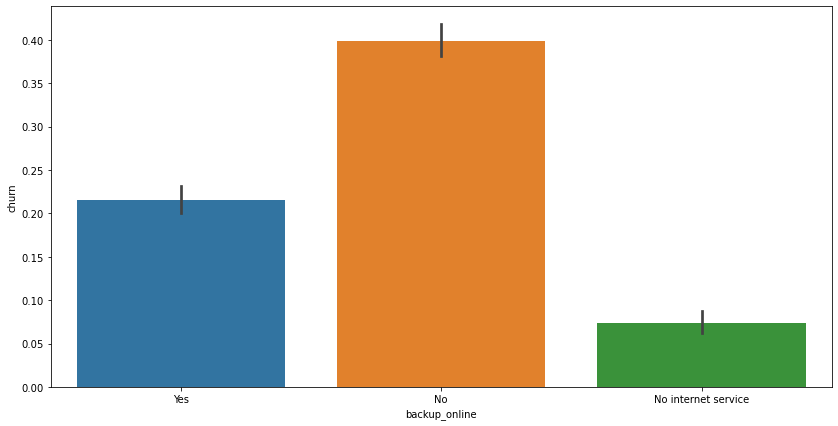

In [35]:
sns.barplot(x='backup_online', y='churn', data=df4);

## 4.3. Análise Multivariada

### 4.3.1. Atributos Numéricos

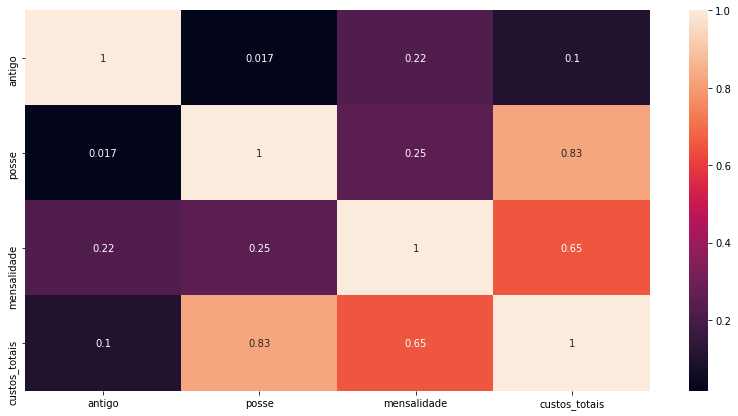

In [36]:
correlation = num_attributes.corr( method = 'pearson' )
sns.heatmap( correlation, annot=True );

# 5.0 PREPARAÇÃO DOS DADOS

In [37]:
df5 = df4.copy()

## 5.1. Encoding

In [38]:
X_cat = cat_attributes[['genero', 'parceiro', 'servico_telefone', 'linhas_multiplas', 'seguranca_online',
       'backup_online', 'protecao_dispositivo', 'suporte_tecnico', 'streaming_tv', 'streaming_video',
        'contrato', 'faturamento_sem_papel', 'metodo_pagamento']]

onn = OneHotEncoder()

X_cat = onn.fit_transform(X_cat).toarray()

X_cat = pd.DataFrame(X_cat)

X_numerical = num_attributes[['antigo', 'posse', 'mensalidade']]

df = pd.concat([X_numerical, X_cat], axis=1)

In [39]:
df_all = pd.concat([df, df5['churn']], axis=1)

## 5.2. Balanceamento da variável resposta

In [40]:
x = df_all.iloc[:,0:40]
y = df_all.iloc[:, -1]

smote = SMOTE()

x, y = smote.fit_resample(x,y)

## 5.3. Rescaling

In [41]:
mms = MinMaxScaler()

x = mms.fit_transform(x)

# 6.0 MODELO DE MACHINE LEARNING

In [42]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

## 6.1. Random Forest

In [43]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [44]:
y_pred = random_forest.predict(X_test)
accuracy_score(y_test, y_pred)*100

100.0

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1058
           1       1.00      1.00      1.00      1012

    accuracy                           1.00      2070
   macro avg       1.00      1.00      1.00      2070
weighted avg       1.00      1.00      1.00      2070



## 6.2. Regressão Logística

In [46]:
regr_logist = LogisticRegression()
regr_logist.fit(X_train, y_train)

LogisticRegression()

In [47]:
y_pred = regr_logist.predict(X_test)
accuracy_score(y_test, y_pred)*100

100.0

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1058
           1       1.00      1.00      1.00      1012

    accuracy                           1.00      2070
   macro avg       1.00      1.00      1.00      2070
weighted avg       1.00      1.00      1.00      2070



## 6.3. Decision Tree

In [49]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [50]:
y_pred = decision_tree.predict(X_test)
accuracy_score(y_test, y_pred)*100

100.0

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1058
           1       1.00      1.00      1.00      1012

    accuracy                           1.00      2070
   macro avg       1.00      1.00      1.00      2070
weighted avg       1.00      1.00      1.00      2070



## 6.4. SVM

In [52]:
svm = SVC()
svm.fit(X_train, y_train)

SVC()

In [53]:
y_pred = svm.predict(X_test)
accuracy_score(y_test, y_pred)*100

100.0

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1058
           1       1.00      1.00      1.00      1012

    accuracy                           1.00      2070
   macro avg       1.00      1.00      1.00      2070
weighted avg       1.00      1.00      1.00      2070



## 6.5. XGBoost

In [55]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

[16:45:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\usuario\.conda\envs\Projeto-Churn\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
y_pred = xgb.predict(X_test)
accuracy_score(y_test, y_pred)*100

100.0

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1058
           1       1.00      1.00      1.00      1012

    accuracy                           1.00      2070
   macro avg       1.00      1.00      1.00      2070
weighted avg       1.00      1.00      1.00      2070



# 7.0 SALVANDO O CLASSIFICADOR

In [58]:
with open('variaveismodelo.pkl', 'wb') as f:
    pickle.dump([smote, onn, mms, random_forest], f)